In [1]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import warnings
warnings.filterwarnings('ignore')

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# The dataset shareable link

#new stylo data
#link = 'https://drive.google.com/open?id=1qg3fx5JyibrfBBycl3y8hCQJWBiXkP2N'
link = 'https://drive.google.com/open?id=15e0XWZR1CYx0nyBOLasWJuwMyFgF-U5l'



fluff, id = link.split('=')
print(id)
filename = 'stylo-data.csv'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile(filename)

#raw_data_link = 'https://drive.google.com/open?id=1DZkGVcBNQ1WUk11dVRzJcbGNeAb8rOaJ'
#stopwords
raw_data_link = 'https://drive.google.com/open?id=1QKJm85j3xeOz4iIgd5D82i7tc3vg0zMW'
fluff, id = raw_data_link.split('=')
print(id)
raw_filename = 'raw_data.csv'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile(raw_filename)


#news stylo dataset

news_link = 'https://drive.google.com/open?id=1C5MS8fWH2yS5GKS_TVddhuXPgR63JC-c'
fluff, id = news_link.split('=')
print(id)
news_filename = 'news-data.csv'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile(news_filename)

15e0XWZR1CYx0nyBOLasWJuwMyFgF-U5l
1QKJm85j3xeOz4iIgd5D82i7tc3vg0zMW
1C5MS8fWH2yS5GKS_TVddhuXPgR63JC-c


In [2]:
import pandas as pd

import numpy as np
from matplotlib import pyplot as plt

import nltk
nltk.download('stopwords')
nltk.download('punkt')

from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer,TfidfVectorizer
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, VarianceThreshold, SelectPercentile, SelectFwe, RFECV,  chi2, f_classif, mutual_info_classif
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer, QuantileTransformer, Normalizer

!pip install -U keras
from keras.utils import np_utils
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.layers import InputLayer, Embedding, Conv1D, MaxPool1D, Dense, Flatten, Dropout, GRU, LSTM, Input
from tensorflow.python.keras import Sequential, Model
from tensorflow.python.keras import Sequential
from keras.initializers import Constant

from pprint import pprint

from imblearn.over_sampling import SMOTE

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.3.1)


Using TensorFlow backend.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


*PS: Para baixar os arquivos do Google Drive, é preciso clicar no link que irá aparecer no console, aceitar as permissões do Drive e em seguida colar o código de verificação no local indicado (console)*

*Sem o arquivo não é possível executar os outros trechos do notebook*

In [0]:
# read dataset
df = pd.read_csv(filename)
raw_df = pd.read_csv(raw_filename)
df_news = pd.read_csv(news_filename)


# Remove single class entries (We need at least 3 samples of an author)#
df = df.groupby('Author').filter(lambda x: len(x) > 3)
raw_df = raw_df.groupby('Author').filter(lambda x: len(x) > 3)

In [0]:
#Separate data from labels

y = df.pop('Author')
y_raw = raw_df.pop('Author')
y_news = df_news.pop('Author')

le = LabelEncoder()
le.fit(y)
encoded_Y = le.transform(y)

le.fit(y_raw)
encoded_raw_Y = le.transform(y_raw)

le.fit(y_news)
encoded_y_news = le.transform(y_news)

In [6]:
y_news

0     'SP'
1     'SP'
2     'SP'
3     'SP'
4     'SP'
      ... 
95    'LE'
96    'LE'
97    'LE'
98    'LE'
99    'LE'
Name: Author, Length: 100, dtype: object

In [7]:
# Feature selection

# Baseline (Variance threshold):
threshold=(.01)
selector = VarianceThreshold(threshold)
selector.fit(df)

df.columns[selector.get_support(indices=True)] # 20 features, data has very low variance (features are mostly very close)

selector.fit(df_news)

df_news.columns[selector.get_support(indices=True)]

Index(['DiversidadeLexica', 'TamanhoMedioDasPalavras', 'TamanhoMedioSentencas',
       'StdevSentencas', 'TamanhoMedioParagrafos', 'StdevTamParagrafos',
       'MediaSilabasPorPalavra', 'Ponto', 'Virgulas', 'Exclamacoes',
       'DoisPontos', 'PronomesPorPreposicao', 'GuiraudR', 'HerdanV', 'MedidaK',
       'DugastU', 'BRFleshIndex'],
      dtype='object')

In [8]:
# 50% better based on percentile using chi2
selector = SelectPercentile(chi2, percentile=50)
selector.fit(df, y)
df.columns[selector.get_support(indices=True)]

Index(['DiversidadeLexica', 'TamanhoMedioDasPalavras', 'TamanhoMedioSentencas',
       'StdevSentencas', 'TamanhoMedioParagrafos', 'StdevTamParagrafos',
       'FrequenciaDeParagrafos', 'Ponto', 'Virgulas', 'Exclamacoes',
       'DoisPontos', 'PronomesPorPreposicao', 'FreqEAbstracao',
       'FreqEAcontecimento', 'FreqECoisa', 'FreqEOrganizacao', 'FreqEObra',
       'FreqEOutro', 'FreqEPessoa', 'FreqETempo', 'FreqEValor', 'GuiraudR',
       'HerdanV', 'DugastU', 'HonoresH', 'FrequenciaDeHapaxLegomenaLocal',
       'BRFleshIndex'],
      dtype='object')

In [9]:
selector = SelectPercentile(chi2, percentile=50)
selector.fit(df_news, y_news)
df.columns[selector.get_support(indices=True)]

Index(['DiversidadeLexica', 'TamanhoMedioDasPalavras', 'TamanhoMedioSentencas',
       'StdevSentencas', 'TamanhoMedioParagrafos', 'StdevTamParagrafos',
       'Ponto', 'Virgulas', 'Exclamacoes', 'DoisPontos', 'FreqCitacoes',
       'FreqAdv', 'FreqPronomes', 'PronomesPorPreposicao',
       'FreqTermosNaoTageados', 'FreqECoisa', 'FreqEObra', 'FreqEOutro',
       'FreqEPessoa', 'FreqETempo', 'FreqEValor', 'GuiraudR', 'HerdanV',
       'DugastU', 'FreqPalavrasErradas', 'FrequenciaDeHapaxLegomenaLocal',
       'BRFleshIndex'],
      dtype='object')

In [10]:
selector = SelectPercentile(percentile=50)
selector.fit(df, y)
df.columns[selector.get_support(indices=True)]

Index(['DiversidadeLexica', 'TamanhoMedioDasPalavras', 'TamanhoMedioSentencas',
       'StdevSentencas', 'TamanhoMedioParagrafos', 'StdevTamParagrafos',
       'FrequenciaDeParagrafos', 'FrequenciaPalavrasDuplicadas',
       'MediaSilabasPorPalavra', 'Ponto', 'Virgulas', 'FreqAdjetivos',
       'FreqVerbosPtcp', 'FreqConj', 'FreqPalavrasFuncionais',
       'FreqTotalEntidadesNomeadas', 'FreqETempo', 'HerdanC', 'HerdanV',
       'MedidaK', 'DugastU', 'MaasA', 'HonoresH',
       'FrequenciaDeHapaxLegomenaLocal', 'FreqPalavrasComunsTam4',
       'FrequenciaStopWords', 'BRFleshIndex'],
      dtype='object')

In [11]:
selector = SelectPercentile(percentile=50)
selector.fit(df_news, y_news)
df.columns[selector.get_support(indices=True)]

Index(['DiversidadeLexica', 'TamanhoMedioDasPalavras',
       'TamanhoMedioParagrafos', 'StdevTamParagrafos',
       'FrequenciaDeParagrafos', 'Virgulas', 'Exclamacoes', 'FreqCitacoes',
       'FreqAdv', 'FreqSubs', 'FreqPrep', 'FreqVerbosPtcp', 'FreqConj',
       'FreqPronomes', 'PronomesPorPreposicao', 'FreqTermosNaoTageados',
       'FreqPalavrasDeConteudo', 'FreqPalavrasFuncionais', 'GuiraudR',
       'HerdanC', 'HerdanV', 'MedidaK', 'DugastU', 'HonoresH',
       'FreqPalavrasErradas', 'FrequenciaDeHapaxLegomenaLocal',
       'FrequenciaStopWords'],
      dtype='object')

In [12]:
# K-Best (chi2)
best_k_features = SelectKBest(chi2, k=54).fit(df, y)
dfscores = pd.DataFrame(best_k_features.scores_)
dfcolumns = pd.DataFrame(df.columns)
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score'] 
print(featureScores.nlargest(54,'Score'))

                           Feature        Score
41                         HerdanV  1640.030726
5               StdevTamParagrafos  1190.145679
4           TamanhoMedioParagrafos  1083.505879
3                   StdevSentencas    83.212074
0                DiversidadeLexica    68.963605
2            TamanhoMedioSentencas    42.317390
43                         DugastU    40.001632
10                        Virgulas    12.506046
9                            Ponto     8.796392
12                      DoisPontos     8.654201
39                        GuiraudR     7.570860
11                     Exclamacoes     5.398750
52                    BRFleshIndex     2.558055
23           PronomesPorPreposicao     2.380678
47  FrequenciaDeHapaxLegomenaLocal     1.056917
1          TamanhoMedioDasPalavras     1.034314
45                        HonoresH     0.898729
30              FreqEAcontecimento     0.542428
37                      FreqETempo     0.538987
35                      FreqEOutro     0

In [13]:
# K-Best (chi2)
best_k_features = SelectKBest(chi2, k=54).fit(df_news, y_news)
dfscores = pd.DataFrame(best_k_features.scores_)
dfcolumns = pd.DataFrame(df.columns)
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score'] 
print(featureScores.nlargest(54,'Score'))

                           Feature        Score
41                         HerdanV  1792.063637
5               StdevTamParagrafos  1685.349566
4           TamanhoMedioParagrafos  1099.484826
2            TamanhoMedioSentencas   840.769641
11                     Exclamacoes    58.801722
3                   StdevSentencas    48.482351
0                DiversidadeLexica    30.839284
43                         DugastU    25.891400
10                        Virgulas    20.952144
39                        GuiraudR    13.163215
12                      DoisPontos    11.441752
9                            Ponto     9.311678
23           PronomesPorPreposicao     6.155300
52                    BRFleshIndex     4.241680
1          TamanhoMedioDasPalavras     1.238665
24           FreqTermosNaoTageados     0.704153
34                       FreqEObra     0.488999
22                    FreqPronomes     0.464900
47  FrequenciaDeHapaxLegomenaLocal     0.405102
35                      FreqEOutro     0

In [14]:
# K-Best (f_classif)
best_k_features = SelectKBest(f_classif, k=54).fit(df, y)
dfscores = pd.DataFrame(best_k_features.scores_)
dfcolumns = pd.DataFrame(df.columns)
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score'] 
print(featureScores.nlargest(54,'Score'))

                           Feature     Score
40                         HerdanC  3.929198
47  FrequenciaDeHapaxLegomenaLocal  3.897632
0                DiversidadeLexica  3.704376
45                        HonoresH  3.677677
3                   StdevSentencas  2.980987
10                        Virgulas  2.902532
7     FrequenciaPalavrasDuplicadas  2.701226
43                         DugastU  2.634572
9                            Ponto  2.433186
44                           MaasA  2.357812
28      FreqTotalEntidadesNomeadas  1.975839
1          TamanhoMedioDasPalavras  1.816000
51             FrequenciaStopWords  1.799109
2            TamanhoMedioSentencas  1.750471
4           TamanhoMedioParagrafos  1.721667
6           FrequenciaDeParagrafos  1.646904
50          FreqPalavrasComunsTam4  1.563717
41                         HerdanV  1.523790
14                   FreqAdjetivos  1.523693
42                         MedidaK  1.509841
37                      FreqETempo  1.461829
5         

Optimal number of features news-dataset: 45
Optimal number of features students-dataset: 35


<Figure size 432x288 with 0 Axes>

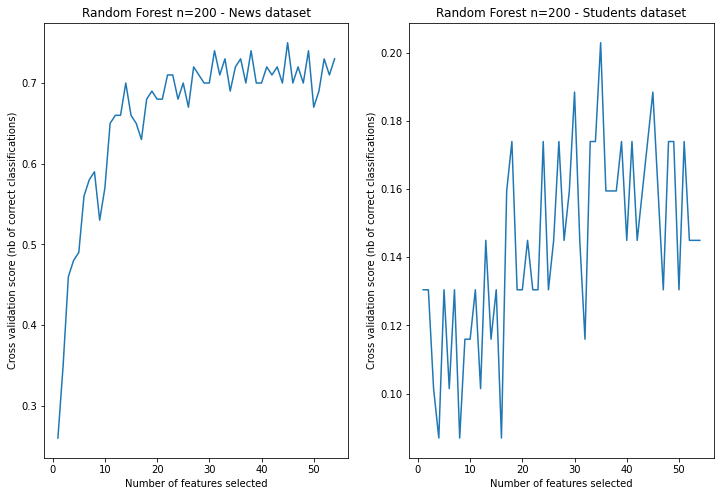

<Figure size 432x288 with 0 Axes>

In [16]:
# Create the RFE object and compute a cross-validated score.
rfc = RandomForestClassifier(n_estimators=200)
# The "accuracy" scoring is proportional to the number of correct classifications

rfecv = RFECV(estimator=rfc, step=1, cv=5,scoring='accuracy')
rfecv.fit(df_news, y_news)

print("Optimal number of features news-dataset: %d" % rfecv.n_features_)

rfecv2 = RFECV(estimator=rfc, step=1, cv=3,
              scoring='accuracy')
rfecv2.fit(df, y)

print("Optimal number of features students-dataset: %d" % rfecv2.n_features_)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(12, 8)

ax1.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
ax1.set_xlabel("Number of features selected")
ax1.set_ylabel("Cross validation score (nb of correct classifications)")
ax1.set_title('Random Forest n=200 - News dataset')

ax2.plot(range(1, len(rfecv2.grid_scores_) + 1), rfecv2.grid_scores_)
ax2.set_xlabel("Number of features selected")
ax2.set_ylabel("Cross validation score (nb of correct classifications)")
ax2.set_title('Random Forest n=200 - Students dataset')

plt.figure()

Optimal number of features : 34


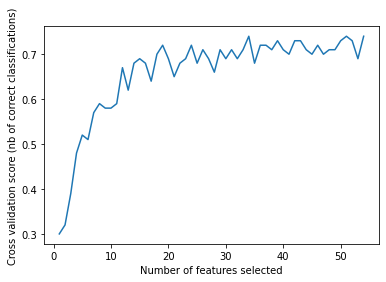

In [17]:
svc = RandomForestClassifier(n_estimators=200)
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=svc, step=1, cv=5,
              scoring='accuracy')
rfecv.fit(df_news, y_news)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [18]:
# Visualize data
df.shape
df.head()
df.shape
raw_df.head()

,Text
1,respostas ecologia evolutiva retirar amostra p...
2,1 - competição membros espécies diferentes usa...
3,embora temática questão ambiental crescente an...
5,vem cada dia buscando entender relações estabe...
6,"pode-se dizer que, conservar dado habitat dada..."


In [0]:
stopwords = nltk.corpus.stopwords.words('portuguese')
raw_df['Text'] = raw_df['Text'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in (stopwords)]))

In [0]:
raw_df = raw_df.replace(to_replace ='\r', value = ' ', regex = True) 
raw_df = raw_df.replace(to_replace ='\n ', value = '\n', regex = True) 
raw_df = raw_df.replace(to_replace ='\n{2,*}', value = ' ', regex = True)

In [21]:
raw_df['Text']

1      respostas ecologia evolutiva retirar amostra p...
2      1 - competição membros espécies diferentes usa...
3      embora temática questão ambiental crescente an...
5      vem cada dia buscando entender relações estabe...
6      pode-se dizer que, conservar dado habitat dada...
                             ...                        
92     referencial teórico: anuras (bufonídeos) sapos...
93     congregação santa – – segunda conferência orga...
94     congregação santa biológicas educação ambienta...
95     disciplina: orientação supervisão estágio ii p...
102    biologia tendências perspectivas atuais aborda...
Name: Text, Length: 69, dtype: object

In [0]:
tfidf_transformer = TfidfTransformer()
X_idf = tfidf_transformer.fit_transform(raw_df['Text'])

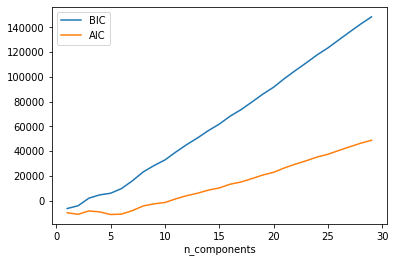

In [23]:
gx = GaussianMixture()

#gx.fit(df)
n_components = np.arange(1, 30)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(df) for n in n_components]
plt.plot(n_components, [m.bic(df) for m in models], label='BIC')
plt.plot(n_components, [m.aic(df) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

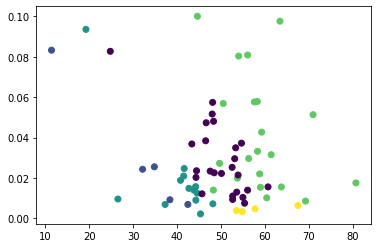

In [24]:
gmm = GaussianMixture(n_components=5)
gmm.fit(df)
labels = gmm.predict(df.values)
plt.scatter(df.values[:, 0], df.values[:, 6], c=labels, cmap='viridis');

In [0]:
scaler = StandardScaler()
# Fit on training set only.
x = scaler.fit_transform(df)

pca = PCA(0.95)
X = pca.fit_transform(x)

In [0]:
#W2Vec tryout
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer,TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# count_vect = CountVectorizer()
# word_count_vector = count_vect.fit_transform(raw_df['Text'])
 
# settings that you use for count vectorizer will go here
#tfidf_vectorizer=TfidfVectorizer(use_idf=True)
 
# just send in all your docs here
#tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(raw_df['Text'])

# tfidf_transformer = TfidfTransformer()
# X_raw = tfidf_transformer.fit_transform(X_train_counts)
#tfidf_vectorizer_vectors[0].to

# for train_index, test_index in kfold.split(X_raw, encoded_raw_Y):
#   X_train, y_train = X_raw[train_index], encoded_raw_Y[train_index]
#   X_test, y_test = X_raw[test_index], encoded_raw_Y[test_index]
#   print(X_raw[train_index])



X_train, X_test, y_train, y_test = train_test_split(raw_df['Text'], encoded_raw_Y, random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [27]:
stopwords = nltk.corpus.stopwords.words('portuguese')
#models = [AdaBoostClassifier(), BaggingClassifier(),ExtraTreesClassifier(), GradientBoostingClassifier(),
           #RandomForestClassifier(), SGDClassifier(), LinearSVC(), SVC(), BernoulliNB(), MultinomialNB(), MLPClassifier() ]

models = [ExtraTreesClassifier(), RandomForestClassifier(), SGDClassifier(), MultinomialNB(), MLPClassifier()]
names = ['extratrees', 'randomf', 'sgdclassfier','multinomialNB', 'mlp']

results = []
accuracies = {}
for idx, model in enumerate(models):
  for ngram in range(1,5):
    clf = make_pipeline(TfidfVectorizer(use_idf=True, stop_words = stopwords, ngram_range=(1, ngram)), model)
    accs = []
    for i in range(0, 10):
      scores = cross_validate(clf, raw_df['Text'], encoded_raw_Y, scoring=['accuracy'], cv=3, return_train_score=True)
      #print(np.mean(scores['test_accuracy']))
      #print(component, names[idx])
      #print(scores['test_accuracy'])
      mean = np.mean(scores['test_accuracy'])
    accs.append(mean)
    results.append((np.mean(accs), ngram, names[idx]))

print(results)
results

[(0.21739130434782608, 1, 'extratrees'), (0.24637681159420288, 2, 'extratrees'), (0.2028985507246377, 3, 'extratrees'), (0.2028985507246377, 4, 'extratrees'), (0.2318840579710145, 1, 'randomf'), (0.24637681159420288, 2, 'randomf'), (0.20289855072463767, 3, 'randomf'), (0.14492753623188406, 4, 'randomf'), (0.18840579710144925, 1, 'sgdclassfier'), (0.1884057971014493, 2, 'sgdclassfier'), (0.20289855072463767, 3, 'sgdclassfier'), (0.2028985507246377, 4, 'sgdclassfier'), (0.17391304347826086, 1, 'multinomialNB'), (0.14492753623188406, 2, 'multinomialNB'), (0.14492753623188406, 3, 'multinomialNB'), (0.14492753623188406, 4, 'multinomialNB'), (0.2318840579710145, 1, 'mlp'), (0.17391304347826086, 2, 'mlp'), (0.2028985507246377, 3, 'mlp'), (0.24637681159420288, 4, 'mlp')]


[(0.21739130434782608, 1, 'extratrees'),
 (0.24637681159420288, 2, 'extratrees'),
 (0.2028985507246377, 3, 'extratrees'),
 (0.2028985507246377, 4, 'extratrees'),
 (0.2318840579710145, 1, 'randomf'),
 (0.24637681159420288, 2, 'randomf'),
 (0.20289855072463767, 3, 'randomf'),
 (0.14492753623188406, 4, 'randomf'),
 (0.18840579710144925, 1, 'sgdclassfier'),
 (0.1884057971014493, 2, 'sgdclassfier'),
 (0.20289855072463767, 3, 'sgdclassfier'),
 (0.2028985507246377, 4, 'sgdclassfier'),
 (0.17391304347826086, 1, 'multinomialNB'),
 (0.14492753623188406, 2, 'multinomialNB'),
 (0.14492753623188406, 3, 'multinomialNB'),
 (0.14492753623188406, 4, 'multinomialNB'),
 (0.2318840579710145, 1, 'mlp'),
 (0.17391304347826086, 2, 'mlp'),
 (0.2028985507246377, 3, 'mlp'),
 (0.24637681159420288, 4, 'mlp')]

In [0]:
# Data normalization/scaling
scaled_features = PowerTransformer().fit_transform(df.values)
df = pd.DataFrame(scaled_features, index=df.index, columns=df.columns)


In [29]:
X, X_test, Y, y_test = train_test_split(df_news.values, encoded_y_news, random_state=7, test_size=0.3)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, random_state=7, test_size=0.5)

model = ExtraTreesClassifier(n_estimators=350, random_state=11)
print(X.shape)
model.fit(X, Y)

print(X_test.shape)
y_pred = model.predict(X_test)

print(y_pred)
print(y_test)
score = accuracy_score(y_test, y_pred)
print("Test score: %.2f%%" % (score * 100))

y_pred = model.predict(X_val)
print(y_pred)
print(y_val)
score = accuracy_score(y_val, y_pred)
print("Validation score: %.2f%%" % (score * 100))

(70, 54)
(15, 54)
[2 6 7 2 7 2 0 2 0 8 2 2 2 4 4]
[2 6 6 8 7 0 0 3 0 8 2 8 2 4 4]
Test score: 66.67%
[3 5 3 1 4 2 1 7 2 2 6 2 8 7 3]
[3 5 1 1 4 8 1 7 2 2 6 8 8 2 3]
Validation score: 73.33%


In [30]:
#stopwords = nltk.corpus.stopwords.words('portuguese')
models = [ExtraTreesClassifier(), 
           RandomForestClassifier(), SVC(kernel='poly'), SVC(), MLPClassifier() ]

names = ['extratrees','randomf', 'svcpoly', 'svcrbf', 'mlp']

#results = []
results2 = []
accuracies = {}
kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=7)
for idx, model in enumerate(models):
  for component in range(5, 48):
    clf = make_pipeline(PCA(n_components=component), model)
    accs = []
    for i in range(0, 10):
      scores = []
      for train_index, test_index in kfold.split(df, encoded_Y):
        X_train, y_train = df.iloc[train_index], encoded_Y[train_index]
        X_test, y_test = df.iloc[test_index], encoded_Y[test_index]
        #X_train_oversampled, y_train_oversampled = SMOTE(k_neighbors=2).fit_sample(X_train, y_train)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        scores.append(accuracy_score(y_test, y_pred))
        #print(np.mean(scores['test_accuracy']))
        #print(component, names[idx])
        #print(scores['test_accuracy'])
      mean = np.mean(scores)
      accs.append(mean)
    results2.append((np.mean(accs), component, names[idx]))
print(results2)

[(0.17663398692810456, 5, 'extratrees'), (0.18815359477124183, 6, 'extratrees'), (0.19133986928104574, 7, 'extratrees'), (0.1793300653594771, 8, 'extratrees'), (0.17058823529411765, 9, 'extratrees'), (0.17908496732026144, 10, 'extratrees'), (0.17181372549019608, 11, 'extratrees'), (0.18341503267973855, 12, 'extratrees'), (0.1853758169934641, 13, 'extratrees'), (0.1883986928104575, 14, 'extratrees'), (0.1901143790849673, 15, 'extratrees'), (0.18235294117647058, 16, 'extratrees'), (0.1935457516339869, 17, 'extratrees'), (0.1849673202614379, 18, 'extratrees'), (0.16911764705882354, 19, 'extratrees'), (0.175, 20, 'extratrees'), (0.19387254901960782, 21, 'extratrees'), (0.17230392156862745, 22, 'extratrees'), (0.1919934640522876, 23, 'extratrees'), (0.18766339869281043, 24, 'extratrees'), (0.16830065359477125, 25, 'extratrees'), (0.1730392156862745, 26, 'extratrees'), (0.18031045751633987, 27, 'extratrees'), (0.18382352941176472, 28, 'extratrees'), (0.17508169934640522, 29, 'extratrees'), (

In [31]:
np.mean(accs)

0.18120915032679738

In [32]:
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=7)
Y = encoded_Y
accuracies = []
variances = []
X = df

models = [ExtraTreesClassifier(), RandomForestClassifier(), MLPClassifier(), SVC(kernel='poly')]
for i in range(0,100):
  scores = []
  for train_index, test_index in kfold.split(X, Y):
      #convert integers to dummy variables (i.e. one hot encoded)
      #dummy_y = np_utils.to_categorical(Y)
      X_train, y_train = X.iloc[train_index], Y[train_index]
      X_test, y_test = X.iloc[test_index], Y[test_index]
      X_train_oversampled, y_train_oversampled = SMOTE(k_neighbors=1).fit_sample(X_train, y_train)
      #rfclf = LinearSVC(multi_class='crammer_singer')
      
      #rfclf = KNeighborsClassifier(n_neighbors=5)
      #rclf = BaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=5), n_estimators=100, random_state=0)
      #rfclf = ExtraTreesClassifier(max_depth=None, n_estimators=500)
      rfclf = LogisticRegression(max_iter=500,solver ='lbfgs')
      #rfclf = RandomForestClassifier(n_estimators=500)
      rfclf.fit(X_train_oversampled, y_train_oversampled)
      y_pred = rfclf.predict(X_test)
      #print(confusion_matrix(y_test,y_pred))
      #print(classification_report(y_test,y_pred))
      #print(accuracy_score(y_test, y_pred))
      scores.append(accuracy_score(y_test, y_pred))

  accuracies.append(np.mean(scores))
print(np.mean(accuracies))

0.16521739130434782


In [33]:
from sklearn.model_selection import cross_val_score
clf = RandomForestClassifier(n_estimators=200, random_state=0)
scores = cross_val_score(clf, X, Y, cv=4)
scores

array([0.16666667, 0.11764706, 0.35294118, 0.29411765])

In [34]:
# Oversampling 
from imblearn.over_sampling import SMOTE


smt = SMOTE(k_neighbors=1)
X_resampled, y_resampled = smt.fit_resample(X_train, y_train)

X_resampled, y_resampled

(array([[-0.55435527, -0.2501882 ,  0.26426935, ...,  1.099827  ,
         -0.34048617,  1.09949053],
        [ 0.20627463, -0.06161256,  0.58115466, ..., -0.40604434,
          0.72685816, -0.94413924],
        [ 3.26473613, -2.43843207, -0.27922395, ..., -0.26862725,
         -0.96006101,  0.41517329],
        ...,
        [-0.22854103,  1.1883863 , -0.62574551, ...,  0.45081812,
          0.14941078,  1.60373883],
        [ 0.45928549, -0.59271705, -0.06906793, ...,  0.55687088,
         -0.09401901,  0.15694371],
        [ 0.37338248, -0.57500306, -0.10807071, ...,  0.35622545,
         -0.00905081,  0.14349321]]),
 array([ 4,  1,  8,  7,  0,  0,  0,  4, 10,  7,  9,  7,  6,  7,  1,  5,  8,
         8,  8,  1,  5,  6,  9,  4,  3,  3,  3,  6,  0, 10,  6,  2,  4,  3,
        10,  6,  7,  0, 10,  2,  7,  0, 10,  6,  0,  1,  1,  1,  1,  2,  2,
         2,  2,  2,  3,  3,  3,  4,  4,  4,  5,  5,  5,  5,  5,  6,  7,  8,
         8,  8,  9,  9,  9,  9,  9, 10, 10]))

In [35]:
# Data split

X_train, X_test, y_train, y_test = train_test_split(df, encoded_Y, test_size=0.3, random_state=0)
#X_test, X_application, y_test, y_application = train_test_split(X_test, y_test, test_size=0.5, random_state=0)

y_train

array([ 8,  9,  7,  7,  0,  2, 10,  6,  0,  6, 10,  4,  9,  4,  0,  5,  7,
        7,  7,  4,  1,  8, 10,  1,  1,  0,  7,  8,  6,  6,  2,  7, 10, 10,
        0,  1,  9,  7,  8,  0,  5,  3,  6,  5,  4,  0,  3, 10])

In [36]:
#Random Forest baseline + accuracy versus test
rfclf = RandomForestClassifier(n_estimators=200, random_state=0)
rfclf.fit(X_resampled, y_resampled)
y_pred = rfclf.predict(X_test)

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[2 0 0 0 0 0 0 0 0 1 0]
 [0 2 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 1 0 0 0 0]
 [0 0 0 2 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 1 2 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0]
 [0 1 0 1 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 1]]
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.67      1.00      0.80         2
           2       1.00      0.50      0.67         2
           3       0.67      0.67      0.67         3
           4       1.00      1.00      1.00         1
           5       0.50      1.00      0.67         1
           6       0.40      0.67      0.50         3
           7       0.00      0.00      0.00         1
           8       1.00      0.33      0.50         3
           9       0.50      1.00      0.67         1
          10       1.00      1.00      1.00         1

    accuracy                           0.67        21
   macro avg       0

In [37]:
# Random Forest hyperparam discovery

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 800, num = 10)]
# Number of features to consider at every split
#max_features = ['auto', 'sqrt']
loss = ['deviance', 'exponential']
learning_rate = [0.1, 0.2, 0.3, 0.4,0.5]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [0, 1, 2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [0, 1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               #'loss': loss,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
               #'learning_rate': learning_rate}
               #'bootstrap': bootstrap}

kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=7)
Y = encoded_Y
scores = []
model = []
best_params = []
X = df
for train_index, test_index in kfold.split(X, Y):
    #convert integers to dummy variables (i.e. one hot encoded)
    #dummy_y = np_utils.to_categorical(Y)
    X_train, y_train = X.iloc[train_index], Y[train_index]
    X_test, y_test = X.iloc[test_index], Y[test_index]
    X_train_oversampled, y_train_oversampled = SMOTE(k_neighbors=1).fit_sample(X_train, y_train)
    hrfclf = ExtraTreesClassifier()
    rf_random = RandomizedSearchCV(estimator = hrfclf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
    rf_random.fit(X_train_oversampled, y_train_oversampled)
    model.append(rf_random.best_estimator_)
    best_params.append(rf_random.best_params_)
    y_pred = rf_random.best_estimator_.predict(X_test)
    #print(confusion_matrix(y_test,y_pred))
    #print(classification_report(y_test,y_pred))
    print(accuracy_score(y_test, y_pred))
    scores.append(accuracy_score(y_test, y_pred))


# Fit the random search model
#rf_random.fit(X_resampled, y_resampled)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   37.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


0.043478260869565216
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   36.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.1min finished


0.21739130434782608
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   36.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.1min finished


0.2608695652173913


In [38]:
best_params

[{'max_depth': None,
  'min_samples_leaf': 2,
  'min_samples_split': 2,
  'n_estimators': 97},
 {'max_depth': None,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 536},
 {'max_depth': 30,
  'min_samples_leaf': 1,
  'min_samples_split': 5,
  'n_estimators': 448}]

In [39]:
y_pred = rf_random.best_estimator_.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.2608695652173913


In [40]:
# RFC w/ tunned HP
rfclf = RandomForestClassifier(bootstrap='True', max_depth=20, max_features='sqrt', n_estimators=900, random_state=0)
rfclf.fit(X_resampled, y_resampled)
pred= rfclf.predict(X_test)
accuracy_score(pred, y_test)

0.2608695652173913

In [0]:
glove_100_link = 'https://drive.google.com/open?id=1hW4DhKFWJJPNIEI3GelC1WLzEqU-lrub'

glove_50_link = 'https://drive.google.com/open?id=10MW2F53DYYxizSXLbvfsphs77Fu1U9Gz'

skip_text_link = 'https://drive.google.com/open?id=1WXpYIhDI8Hhne3cOZUQshScjwsWO2wRR'

cbow_link = 'https://drive.google.com/open?id=1o6bO6QDAOFd_bASWuZHfbBlk8OBNA0uQ'

def load_file(link, filename):
  # Download gloVe word embedding for portuguese-BR (100-dimensions)
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  fluff, id = link.split('=')
  downloaded = drive.CreateFile({'id':id})
  downloaded.GetContentFile(filename)

def build_embedding_dict(filename):
  embd_dict = {}
  with open(filename, 'r', encoding='utf-8') as f:
    for line in f:
      word, coefs = line.split(maxsplit=1)
      coefs = np.fromstring(coefs, 'f', sep=' ')
      embd_dict[word] = coefs
  return embd_dict
  

In [0]:
# Download and load embeddings into dictionaries (eg: {'oi' : n1, n2, ..., n100})

load_file(glove_100_link, 'glove_100.txt')
load_file(glove_50_link, 'glove_50.txt')
load_file(cbow_link, 'cbow_50.txt')
load_file(skip_text_link, 'skipgram_50.txt')

word_embedding_dict_50 = build_embedding_dict('glove_50.txt')
word_embedding_dict_100 = build_embedding_dict('glove_100.txt')
word_embedding_cbow_50 = build_embedding_dict('cbow_50.txt')
word_embedding_skipgram_50 = build_embedding_dict('skipgram_50.txt')

In [0]:
corpus = raw_df['Text']

# Create a Keras tokenizer and convert words to integer values
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(corpus)

# Convert strings to their corresponding integer value created by the Tokenizer
embedded_sentences = tokenizer.texts_to_sequences(corpus)
print(embedded_sentences)

In [0]:
corpus

In [45]:
max_words_text = max(corpus, key=lambda sentence: len(nltk.word_tokenize(sentence, language='portuguese')))
print(max_words_text[:200])

biologia tendências perspectivas atuais abordagem sala aula texto disponibilizado sala aula virtual, histórico ciências, deve ter percebido modificações ocorridas estreita relação transformações polít


In [46]:
max_sentence_len = len(nltk.word_tokenize(max_words_text, language='portuguese'))
print(max_sentence_len)

3913


In [47]:
# Make all the sentences have the same length by padding with 0s at the end
padded_sentences = pad_sequences(embedded_sentences, max_sentence_len, padding='post')

padded_sentences.shape

(69, 3913)

In [0]:
vocab_len = len(tokenizer.word_index) + 1

# Create an embedding matrix, in other words, use the weights from gloVe vector against all our corpus
# In the end we will have a matrix of all our vocabulary x N dimensions
def build_embd_matrix(size, embd_dic):
  # initialize with all zeros
  embedding_matrix = np.zeros((vocab_len, size))
  for word, index in tokenizer.word_index.items():
    embedding_vector = embd_dic.get(word)
    # if the word is in gloVe, we will use its weigths 
    if embedding_vector is not None:
      embedding_matrix[index] = embedding_vector[:size]
  return embedding_matrix


embedding_matrix_50 = build_embd_matrix(50, word_embedding_dict_50)

embedding_matrix_100 = build_embd_matrix(100, word_embedding_dict_100)

embedding_matrix_cbow_50 = build_embd_matrix(50, word_embedding_cbow_50)

embedding_matrix_skipgram_50 = build_embd_matrix(50, word_embedding_skipgram_50)

In [50]:
# TODO: Update this model to user TensorFlow 2.x
model = Sequential()
model.add(Embedding(vocab_len, 50,weights=[embedding_matrix_50], input_length=max_sentence_len))
model.add(Dropout(0.5))
model.add(Conv1D(64, 5, activation='relu'))

model.add(MaxPool1D(2, strides=2))
model.add(Flatten())
model.add(Dense(11, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['acc'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 3913, 50)          250200    
_________________________________________________________________
dropout (Dropout)            (None, 3913, 50)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 3909, 64)          16064     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1954, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 125056)            0         
_________________________________________________________________
dense (Dense)                (None, 11)                1375627   
Total params: 1,641,891
Trainable params: 1,641,891
Non-trainable params: 0
____________________________________________

In [53]:
X = padded_sentences
Y = np_utils.to_categorical(encoded_Y)
model.fit(X, Y, epochs=50, verbose=1)

Epoch 1/50
3/3 [==============================] - 1s 187ms/step - loss: 5.0218 - acc: 0.0870
Epoch 2/50
3/3 [==============================] - 1s 182ms/step - loss: 2.5624 - acc: 0.2609
Epoch 3/50
3/3 [==============================] - 1s 181ms/step - loss: 1.7085 - acc: 0.4638
Epoch 4/50
3/3 [==============================] - 1s 181ms/step - loss: 1.0356 - acc: 0.6812
Epoch 5/50
3/3 [==============================] - 1s 177ms/step - loss: 0.8874 - acc: 0.7681
Epoch 6/50
3/3 [==============================] - 1s 178ms/step - loss: 0.8151 - acc: 0.7681
Epoch 7/50
3/3 [==============================] - 1s 180ms/step - loss: 0.7911 - acc: 0.8406
Epoch 8/50
3/3 [==============================] - 1s 178ms/step - loss: 0.4871 - acc: 0.8261
Epoch 9/50
3/3 [==============================] - 1s 178ms/step - loss: 0.6800 - acc: 0.8696
Epoch 10/50
3/3 [==============================] - 1s 179ms/step - loss: 0.3977 - acc: 0.9275
Epoch 11/50
3/3 [==============================] - 1s 182ms/step - lo

In [0]:
def build_model(embd_matrix, size=50):
  model = Sequential()
  embedding_layer = Embedding(vocab_len, 50, input_length=max_sentence_len, 
                              embeddings_initializer=Constant(embedding_matrix_50), trainable=False)
  model.add(embedding_layer)
  model.add(Dropout(0.3))
  model.add(Flatten())
  number_of_classes = len(np_utils.to_categorical(encoded_raw_Y)[0])
  model.add(Dense(number_of_classes, activation='softmax'))

  model.compile(optimizer='rmsprop',
                    loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [57]:
cv_scores = []
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=7)
models = []

X = padded_sentences

X, X_val, Y_train, y_val = train_test_split(padded_sentences, encoded_raw_Y, stratify=encoded_raw_Y, random_state=11, test_size=0.20)

accs = []
for i in range(0,10):
  # stratified k-fold validation
  for train_index, test_index in kfold.split(X, Y_train):
    model = build_model(embd_matrix=embedding_matrix_100)
    
    # Convert integers to vectors (e.g One hot encoding)
    Y = np_utils.to_categorical(Y_train)

    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

    # train the model
    model.fit(X_train, y_train, epochs=50, verbose=0)

    # Evaluate the model
    scores = model.evaluate(X_test, y_test)
    #print("%s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))
    cv_scores.append(scores[1] * 100)
  accs.append(np.mean(cv_scores))

# Brief summary of the scores
print("%.2f%% (+/- %.2f%%)" % (np.mean(accs), np.std(accs)))

1/1 [==============================] - 0s 1ms/step - loss: 4.5791 - accuracy: 0.2222
24.97% (+/- 2.81%)


In [58]:
y_val.shape
y_val_dummy = np_utils.to_categorical(y_val)
X_val.shape

(14, 3913)

In [59]:
scores = model.evaluate(X_val, y_val_dummy)
print("Test score: %.2f%%" % (scores[1] * 100))

1/1 [==============================] - 0s 1ms/step - loss: 7.8574 - accuracy: 0.0714
Test score: 7.14%


In [0]:
#scores = model.evaluate(X_val, y_val_dummy)

X, X_val, Y_train, y_val = train_test_split(padded_sentences, encoded_raw_Y, random_state=11, stratify=encoded_raw_Y, test_size=0.20)

In [0]:
def test_model(iter, embedding, name, epochs):
  test_scores = []
  val_scores = []
  for i in range(iter):
    Y = np_utils.to_categorical(encoded_raw_Y)

    X, X_test, Y, y_test = train_test_split(padded_sentences, Y, stratify=Y, random_state=11, test_size=0.2)
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, random_state=11, test_size=0.5)

    model = build_model(embedding, 100)

    model.fit(X, Y, epochs=epochs, verbose=0)
    scores = model.evaluate(X_test, y_test)

    #print("Test score " + name + ": %.2f%%" % (scores[1] * 100))
    test_scores.append(scores[1] * 100)

    scores = model.evaluate(X_val, y_val)
    #print("Validation score " + name + ": %.2f%%" % (scores[1] * 100))
    val_scores.append(scores[1] * 100)
  print("Mean test scores:" + ": %.2f%%" % (np.mean(test_scores)))
  print("Mean val scores:" + ": %.2f%%" % (np.mean(val_scores)))

In [62]:
# Run and print models output
test_model(10,embedding_matrix_50, 'Glove 50D', 150)
test_model(10,embedding_matrix_100,'Glove 100D', 150 )
test_model(10,embedding_matrix_cbow_50, 'CBOW 50D', 150)
test_model(10,embedding_matrix_skipgram_50, 'SkipGram 50D', 150)

1/1 [==============================] - 0s 1ms/step - loss: 6.2562 - accuracy: 0.0000e+00
Test score Glove 100D: 0.00%
1/1 [==============================] - 0s 1ms/step - loss: 2.7050 - accuracy: 0.1429
Validation score Glove 100D: 14.29%
1/1 [==============================] - 0s 1ms/step - loss: 6.2642 - accuracy: 0.0000e+00
Test score Glove 100D: 0.00%
1/1 [==============================] - 0s 1ms/step - loss: 2.8893 - accuracy: 0.2857
Validation score Glove 100D: 28.57%
1/1 [==============================] - 0s 1ms/step - loss: 5.5345 - accuracy: 0.1429
Test score Glove 100D: 14.29%
1/1 [==============================] - 0s 949us/step - loss: 2.4820 - accuracy: 0.1429
Validation score Glove 100D: 14.29%
1/1 [==============================] - 0s 1ms/step - loss: 5.9260 - accuracy: 0.1429
Test score Glove 100D: 14.29%
1/1 [==============================] - 0s 1ms/step - loss: 2.6927 - accuracy: 0.1429
Validation score Glove 100D: 14.29%
1/1 [==============================] - 0s 1ms/st

In [63]:
# Brief summary of the scores
print("%.2f%% (+/- %.2f%%)" % (np.mean(cv_scores), np.std(cv_scores)))

22.23% (+/- 5.49%)


In [0]:
# Save and upload model

model_json = model.to_json()
with open('model-lstm-2.json', 'w') as json_file:
  json_file.write(model_json)
model.save_weights('model-lstm-2.h5')

uploaded = drive.CreateFile({'title': 'model-lstm-2.h5'})
uploaded.SetContentFile('model-lstm-2.h5')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

uploaded = drive.CreateFile({'title': 'model-lstm-2.json'})
uploaded.SetContentFile('model-lstm-2.json')
uploaded.Upload()


In [0]:
!ls -la

In [0]:
from google.colab import files
files.download('model-lstm.h5')